### Corex transformer on synthetic data

In [1]:
# Import necessary libraries
import os
import math
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

# Import the SyntheticData class from factor_eval.py
# Make sure factor_eval.py is in the same directory as your notebook
from factor_eval import SyntheticData

# Set the random seed for reproducibility
seed = 42
n_samples = 50000
n_test = 12500
n_sources = 5
k = 30
snr = 2
correlate_sources = 0.6
get_covariance = False
random_scale = True
nuisance = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Generate synthetic data
# We want:
# - 50,000 training samples, 12,500 test samples
# - 5 latent factors (n_sources=5), k=10 variables per factor => 1170 observed variables in total
# - SNR = 0.5 for moderate noise
# - No correlation between sources (correlate_sources=False)
# - No nuisance variables (nuisance=0)
# - Use a fixed seed for reproducibility
synthetic_data = SyntheticData(
    n_samples=n_samples,
    n_test=n_test, 
    n_sources=n_sources,
    k=k,
    snr=snr,             # Lower SNR to increase noise
    correlate_sources=correlate_sources,  # Introduce correlation among latent factors
    get_covariance=get_covariance,
    random_scale=random_scale,    # Randomly scale variables for additional complexity
    nuisance=nuisance,           # No nuisance variables
    seed=seed               # Fixed seed for reproducibility
)

n_observed = synthetic_data.train.shape[1]
# Extract training and test sets
X_train = synthetic_data.train
X_test = synthetic_data.test

# -------------------------- Normalization Block (BEGIN) --------------------------
# Compute min and max from the training data
train_min = np.min(X_train, axis=0, keepdims=True)
train_max = np.max(X_train, axis=0, keepdims=True)

# Apply min-max normalization: (X - min) / (max - min)
# Handle the case where max == min to avoid division by zero (if any variable is constant)
denominator = (train_max - train_min)
denominator[denominator == 0] = 1e-8  # A small number to avoid division by zero

X_train = (X_train - train_min) / denominator
X_test = (X_test - train_min) / denominator
# -------------------------- Normalization Block (END) --------------------------

# Convert the data to PyTorch tensors
train_tensor = torch.tensor(X_train, dtype=torch.float32)
test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create TensorDatasets for training and test sets
train_dataset = TensorDataset(train_tensor)
test_dataset = TensorDataset(test_tensor)

# Create a generator for deterministic shuffling
generator = torch.Generator()
generator.manual_seed(seed)

# We don't need to do a random split now since SyntheticData already provides train/test sets
# We'll just create a RandomSampler for the train dataset to ensure reproducible shuffling
train_sampler = RandomSampler(train_dataset, generator=generator)

# Create DataLoaders for training and test sets
batch_size = 32  # Adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Display shapes and verify
print(f"Training Data Shape: {X_train.shape}")
print(f"Test Data Shape: {X_test.shape}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Training Data Shape: (50000, 150)
Test Data Shape: (12500, 150)
Number of training batches: 1563
Number of test batches: 391


In [2]:
# Let's print the first 5 rows of the training data
print("First 5 rows of training data:")
print(X_train[:5])

# Let's also print summary statistics of the first few columns to see their distribution
num_cols_to_inspect = 5  # you can change this number
cols_to_inspect = X_train[:, :num_cols_to_inspect]

print("\nSummary statistics for the first 5 columns of the training data:")
means = cols_to_inspect.mean(axis=0)
stds = cols_to_inspect.std(axis=0)
mins = cols_to_inspect.min(axis=0)
maxs = cols_to_inspect.max(axis=0)

for i in range(num_cols_to_inspect):
    print(f"Column {i}: mean={means[i]:.4f}, std={stds[i]:.4f}, min={mins[i]:.4f}, max={maxs[i]:.4f}")

First 5 rows of training data:
[[0.43111964 0.57192405 0.44824362 0.55436165 0.50653324 0.59520419
  0.46561595 0.40183786 0.56137316 0.57269466 0.5709691  0.41344147
  0.45109352 0.53744063 0.43445677 0.58800094 0.50028035 0.53974035
  0.52038248 0.6009922  0.62424905 0.49413582 0.42328905 0.5376404
  0.59989813 0.47019549 0.59878195 0.61371842 0.45728399 0.52058608
  0.5862939  0.51467814 0.51813157 0.54765757 0.50313808 0.45971991
  0.44905747 0.52582553 0.40201433 0.50531426 0.59372358 0.60392779
  0.4547658  0.57455353 0.55485395 0.57067661 0.58705232 0.48058554
  0.43679406 0.65920146 0.46600817 0.51592367 0.60054449 0.53897319
  0.61141477 0.73140944 0.54682069 0.56018181 0.52439651 0.47090059
  0.67482663 0.55978934 0.61522712 0.57893057 0.55525488 0.76983645
  0.52877175 0.63693929 0.51226288 0.57832693 0.56893796 0.49476022
  0.58009677 0.64563997 0.57010478 0.55229641 0.59960046 0.5279906
  0.5081487  0.61053354 0.69157085 0.48150502 0.5713509  0.58872891
  0.6909455  0.5032

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Encoder class with explicit layer definitions and assert statements
class Encoder(nn.Module):
    def __init__(self, input_dim=n_observed, hidden_dims=[128, 64], output_dim=5, embedding_dim=64):
        super(Encoder, self).__init__()

        # Assertions for input dimensions
        assert input_dim == n_observed, f"Expected input_dim to be 50, but got {input_dim}"
        assert output_dim == 5, f"Expected output_dim to be 5, but got {output_dim}"
        assert embedding_dim == 64, f"Expected embedding_dim to be 64, but got {embedding_dim}"

        # Define the layers explicitly
        self.layers = nn.ModuleList()
        dims = [input_dim] + hidden_dims + [output_dim]

        # Create Linear layers
        for i in range(len(dims) - 1):
            in_features = dims[i]
            out_features = dims[i + 1]
            layer = nn.Linear(in_features, out_features)
            self.layers.append(layer)

        # Learnable embedding vectors e_i for each z_i
        self.e = nn.Parameter(torch.randn(output_dim, embedding_dim))
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim

        # Assert the number of Linear layers
        expected_num_linear_layers = len(hidden_dims) + 1  # Number of hidden layers + output layer
        actual_num_linear_layers = len(self.layers)
        assert actual_num_linear_layers == expected_num_linear_layers, \
            f"Expected {expected_num_linear_layers} Linear layers, but got {actual_num_linear_layers}"

        # Assert the input and output dimensions of the Linear layers
        # First Linear layer
        first_linear = self.layers[0]
        assert first_linear.in_features == n_observed, \
            f"Expected first Linear layer to have input features 50, but got {first_linear.in_features}"

        # Last Linear layer
        last_linear = self.layers[-1]
        assert last_linear.out_features == 5, \
            f"Expected last Linear layer to have output features 5, but got {last_linear.out_features}"

        # Assert the shape of e
        assert self.e.shape == (5, 64), \
            f"Expected embedding matrix e to have shape (5, 64), but got {self.e.shape}"

    def forward(self, x):
        # Assert the input shape
        assert x.dim() == 2, f"Expected input x to be a 2D tensor, but got {x.dim()}D tensor"
        assert x.shape[1] == n_observed, f"Expected input x to have 50 features, but got {x.shape[1]}"

        batch_size = x.size(0)

        # Pass the input through the Linear layers with ReLU activations
        for i, layer in enumerate(self.layers):
            x = layer(x)
            # Apply ReLU after each hidden layer except the last layer
            if i < len(self.layers) - 1:
                x = F.relu(x)

        Z = x  # Shape: (batch_size, output_dim)

        # Assert the shape of Z
        assert Z.shape == (batch_size, 5), \
            f"Expected Z to have shape ({batch_size}, 5), but got {Z.shape}"

        # Convert Z to \hat Z by multiplying each scalar z_i with its own embedding vector e_i
        Z_expanded = Z.unsqueeze(2)  # Shape: (batch_size, output_dim, 1)
        assert Z_expanded.shape == (batch_size, 5, 1), \
            f"Expected Z_expanded to have shape ({batch_size}, 5, 1), but got {Z_expanded.shape}"

        e_expanded = self.e.unsqueeze(0)  # Shape: (1, output_dim, embedding_dim)
        assert e_expanded.shape == (1, 5, 64), \
            f"Expected e_expanded to have shape (1, 5, 64), but got {e_expanded.shape}"

        # Multiply Z_expanded and e_expanded to get hat_Z
        hat_Z = Z_expanded * e_expanded  # Shape: (batch_size, output_dim, embedding_dim)
        assert hat_Z.shape == (batch_size, 5, 64), \
            f"Expected hat_Z to have shape ({batch_size}, 5, 64), but got {hat_Z.shape}"

        return hat_Z

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self, input_dim=n_observed, embedding_dim=64, hidden_dims=[]):
        super(Decoder, self).__init__()
        self.input_dim = input_dim      # Number of observed variables (n)
        self.embedding_dim = embedding_dim

        # Assert input dimensions
        assert input_dim == n_observed, f"Expected input_dim to be 50, but got {input_dim}"
        assert embedding_dim == 64, f"Expected embedding_dim to be 64, but got {embedding_dim}"

        # Learnable query embeddings (e1, e2, ..., en)
        self.query_embeddings = nn.Parameter(torch.randn(input_dim, embedding_dim))

        # Assert query_embeddings shape
        assert self.query_embeddings.shape == (n_observed, 64), \
            f"Expected query_embeddings to have shape (50, 64), but got {self.query_embeddings.shape}"

        # MultiheadAttention module with 1 head
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=1, batch_first=True)

        # Layer normalization
        self.layer_norm = nn.LayerNorm(embedding_dim)

        # Define individual MLPs for each observed variable
        dims = [embedding_dim] + hidden_dims + [1]

        # Create MLPs for each observed variable
        self.mlp_layers = nn.ModuleList([
            nn.Sequential(*[
                nn.Linear(dims[i], dims[i + 1]) if i == len(dims) - 2 else nn.Sequential(
                    nn.Linear(dims[i], dims[i + 1]),
                    nn.ReLU()
                )
                for i in range(len(dims) - 1)
            ])
            for _ in range(input_dim)
        ])

        # Assert that we have one MLP per observed variable
        assert len(self.mlp_layers) == n_observed, \
            f"Expected 50 MLPs in mlp_layers, but got {len(self.mlp_layers)}"

        # Verify that MLPs do not share parameters
        mlp_params = [set(mlp.parameters()) for mlp in self.mlp_layers]
        for i in range(len(mlp_params)):
            for j in range(i + 1, len(mlp_params)):
                assert mlp_params[i].isdisjoint(mlp_params[j]), \
                    f"MLP {i} and MLP {j} share parameters"

    def forward(self, hat_Z):
        """
        hat_Z: Tensor of shape (batch_size, output_dim, embedding_dim)
        """
        # Assert the shape of hat_Z
        assert hat_Z.dim() == 3, f"Expected hat_Z to be a 3D tensor, but got {hat_Z.dim()}D tensor"
        batch_size, output_dim, embedding_dim = hat_Z.shape
        assert embedding_dim == 64, \
            f"Expected hat_Z embedding_dim to be 64, but got {embedding_dim}"
        assert output_dim == 5, \
            f"Expected hat_Z output_dim to be 5, but got {output_dim}"

        # Prepare query embeddings and expand to batch size
        query_embeddings = self.query_embeddings.unsqueeze(0).expand(batch_size, -1, -1)  # Shape: (batch_size, input_dim, embedding_dim)
        assert query_embeddings.shape == (batch_size, n_observed, 64), \
            f"Expected query_embeddings to have shape ({batch_size}, 50, 64), but got {query_embeddings.shape}"

        # Apply scaled dot-product attention
        attn_output, attn_weights = self.attention(query_embeddings, hat_Z, hat_Z)  # Output shape: (batch_size, input_dim, embedding_dim)
        assert attn_output.shape == (batch_size, n_observed, 64), \
            f"Expected attn_output to have shape ({batch_size}, 50, 64), but got {attn_output.shape}"
        assert attn_weights.shape == (batch_size, n_observed, 5), \
            f"Expected attn_weights to have shape ({batch_size}, 50, 5), but got {attn_weights.shape}"

        # Add residual connection and apply layer normalization
        out = self.layer_norm(attn_output + query_embeddings)  # Shape: (batch_size, input_dim, embedding_dim)
        assert out.shape == (batch_size, n_observed, 64), \
            f"Expected out to have shape ({batch_size}, n_observed, 64), but got {out.shape}"

        # Pass each context vector through its corresponding MLP
        x_hat = []
        for i in range(self.input_dim):
            x_i = out[:, i, :]  # Shape: (batch_size, embedding_dim)
            assert x_i.shape == (batch_size, 64), \
                f"Expected x_i to have shape ({batch_size}, 64), but got {x_i.shape}"

            x_i_hat = self.mlp_layers[i](x_i)  # Shape: (batch_size, 1)
            assert x_i_hat.shape == (batch_size, 1), \
                f"Expected x_i_hat to have shape ({batch_size}, 1), but got {x_i_hat.shape}"

            x_hat.append(x_i_hat)
        x_hat = torch.cat(x_hat, dim=1)  # Shape: (batch_size, input_dim)
        assert x_hat.shape == (batch_size, n_observed), \
            f"Expected x_hat to have shape ({batch_size}, 50), but got {x_hat.shape}"

        return x_hat, attn_weights  # Return attention weights

In [5]:
class Model(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim, encoder_hidden_dims=[], decoder_hidden_dims=[]):
        super(Model, self).__init__()
        self.encoder = Encoder(
            input_dim=input_dim,
            output_dim=output_dim,
            embedding_dim=embedding_dim,
            hidden_dims=encoder_hidden_dims
        )
        self.decoder = Decoder(
            input_dim=input_dim,
            embedding_dim=embedding_dim,
            hidden_dims=decoder_hidden_dims
        )

    def forward(self, x):
        hat_Z = self.encoder(x)     # Obtain \hat{Z} from the encoder
        x_hat, attn_weights = self.decoder(hat_Z)  # Reconstruct x from \hat{Z} using the decoder
        return x_hat, attn_weights


In [6]:
import os
import math
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import adjusted_rand_score
from torch.utils.data import DataLoader, TensorDataset

# Assume 'synthetic_data' and 'model' are already defined.
# Also assume 'train_loader' and 'test_loader' are defined from previous code.

# Extract parameters from synthetic_data
input_dim = synthetic_data.train.shape[1]  # Number of observed variables
output_dim = synthetic_data.n_sources       # Number of latent factors

# true_labels: Use the clusters from synthetic_data directly
true_labels = np.array(synthetic_data.clusters, dtype=int)
assert np.all(true_labels >= -1), "Some observed variables have invalid cluster labels."

# Define dimensions
input_dim = n_observed  # Number of observed variables
output_dim = 5               # Output dimension of the encoder (number of factors)
embedding_dim = 64           # Embedding dimension for the embeddings e and e_i's
encoder_hidden_dims = [128, 64]  # Hidden dimensions for the encoder
decoder_hidden_dims = [64, 32]   # Hidden dimensions for the decoder

# Instantiate the model
model = Model(
    input_dim=input_dim,
    output_dim=output_dim,
    embedding_dim=embedding_dim,
    encoder_hidden_dims=encoder_hidden_dims,
    decoder_hidden_dims=decoder_hidden_dims
)

# Move the model to the appropriate device (GPU if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 20         # Number of epochs
print_every = 1          # How often to print loss (in epochs)

# Define the maximum value for the entropy regularization coefficient
max_lambda_entropy =  2 * 1e-3  # Adjust this value as needed

# Flag to enable or disable entropy regularizer
use_entropy_regularizer = True # Set to True to enable entropy regularization

def get_lambda_entropy(epoch, num_epochs, max_lambda_entropy, schedule_type='exponential', use_entropy_regularizer=True):
    if not use_entropy_regularizer:
        return 0.0
    if schedule_type == 'constant':
        # Always return max_lambda_entropy
        return max_lambda_entropy
    elif schedule_type == 'linear':
        # Linear increase from 0 to max_lambda_entropy
        return max_lambda_entropy * (epoch / num_epochs)
    elif schedule_type == 'exponential':
        # Exponential increase from 0 to max_lambda_entropy
        k = 5  # Adjust this value to control the rate of increase
        numerator = math.exp(k * epoch / num_epochs) - 1
        denominator = math.exp(k) - 1
        return max_lambda_entropy * (numerator / denominator)
    elif schedule_type == 'logarithmic':
        # Logarithmic increase from 0 to max_lambda_entropy
        if epoch == 0:
            return 0.0
        else:
            return max_lambda_entropy * math.log(epoch + 1) / math.log(num_epochs + 1)
    else:
        raise ValueError(f"Unknown schedule_type: {schedule_type}")

def compute_ari_per_sample(true_labels, predicted_labels):
    """
    Computes the ARI between true_labels and predicted_labels.
    Both true_labels and predicted_labels should be 1D arrays of the same length.
    If there are -1 labels (nuisance), they will be filtered out.
    """
    # Filter out nuisance variables (-1)
    mask = true_labels != -1
    filtered_true = true_labels[mask]
    filtered_pred = predicted_labels[mask]

    if len(filtered_true) == 0:
        # No variables to compare, default ARI to 1.0 (no meaningful difference)
        return 1.0
    ari = adjusted_rand_score(filtered_true, filtered_pred)
    return ari

# Load the trained model if it exists
model_path = "trained_model.pth"
if os.path.exists(model_path):
    print("Trained model found. Loading the model.")
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint)
    print("Model loaded successfully!")
else:
    print("No trained model found. Starting training from scratch.")

# Initialize a list to store the average attention matrices per epoch
attention_matrices = []

# More interpretable entropy normalization
ent_norm = 1.0 / (input_dim * math.log(output_dim))

# Initialize lists to store ARIs
train_ari_list = []
test_ari_list = []  # Using 'test_ari_list' instead of 'val_ari_list'

# Training loop with testing
for epoch in range(num_epochs):
    # Compute lambda_entropy for the current epoch
    lambda_entropy = get_lambda_entropy(
        epoch, num_epochs, max_lambda_entropy, schedule_type='exponential', use_entropy_regularizer=use_entropy_regularizer
    )

    # Assert that lambda_entropy is within expected bounds
    assert lambda_entropy >= 0.0, f"Lambda entropy should be non-negative, got {lambda_entropy}"
    assert lambda_entropy <= max_lambda_entropy, f"Lambda entropy should not exceed max_lambda_entropy ({max_lambda_entropy}), got {lambda_entropy}"

    # Training phase
    model.train()
    running_loss = 0.0
    running_recon_loss = 0.0
    running_entropy_loss = 0.0
    epoch_attn_weights = []
    epoch_ari = []

    for batch_idx, (batch,) in enumerate(train_loader):
        batch = batch.to(device)
        batch_size = batch.size(0)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        x_hat, attn_weights = model(batch)

        # Reconstruction loss
        recon_loss = criterion(x_hat, batch)

        # Entropy regularizer
        entropy_regularizer = 0.0
        epsilon = 1e-8
        entropy = -torch.sum(attn_weights * torch.log(attn_weights + epsilon), dim=2)
        entropy_regularizer = ent_norm * torch.mean(torch.sum(entropy, dim=1))

        # Total loss
        loss = recon_loss + lambda_entropy * entropy_regularizer

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Accumulate losses
        running_loss += loss.item()
        running_recon_loss += recon_loss.item()
        running_entropy_loss += entropy_regularizer.item()

        # Compute ARI per sample
        attn_weights_np = attn_weights.detach().cpu().numpy()
        batch_ari_values = []
        for i in range(batch_size):
            predicted_labels = np.argmax(attn_weights_np[i], axis=1)
            ari = compute_ari_per_sample(true_labels, predicted_labels)
            batch_ari_values.append(ari)
        avg_ari_batch = np.mean(batch_ari_values)
        epoch_ari.append(avg_ari_batch)

        epoch_attn_weights.append(attn_weights.detach().cpu())

    # Compute average training losses and ARI
    avg_train_loss = running_loss / len(train_loader)
    avg_train_recon_loss = running_recon_loss / len(train_loader)
    avg_train_entropy_loss = running_entropy_loss / len(train_loader)
    avg_train_ari = np.mean(epoch_ari)
    train_ari_list.append(avg_train_ari)

    # Compute average attention matrix for the epoch
    epoch_attn_weights_tensor = torch.cat(epoch_attn_weights, dim=0)
    avg_attn_weights_epoch = epoch_attn_weights_tensor.mean(dim=0)
    avg_attn_weights_epoch_np = avg_attn_weights_epoch.numpy()
    attention_matrices.append(avg_attn_weights_epoch_np.T)

    # Testing phase
    model.eval()
    test_loss = 0.0
    test_recon_loss = 0.0
    test_entropy_loss = 0.0
    epoch_ari_test = []

    with torch.no_grad():
        for batch_idx, (batch,) in enumerate(test_loader):
            batch = batch.to(device)
            batch_size = batch.size(0)

            # Forward pass
            x_hat, attn_weights = model(batch)

            # Reconstruction loss
            recon_loss = criterion(x_hat, batch)

            # Entropy regularizer
            epsilon = 1e-8
            entropy = -torch.sum(attn_weights * torch.log(attn_weights + epsilon), dim=2)
            entropy_regularizer = ent_norm * torch.mean(torch.sum(entropy, dim=1))

            # Total loss
            loss = recon_loss + lambda_entropy * entropy_regularizer

            # Accumulate test losses
            test_loss += loss.item()
            test_recon_loss += recon_loss.item()
            test_entropy_loss += entropy_regularizer.item()

            # Compute ARI on test set
            attn_weights_np = attn_weights.detach().cpu().numpy()
            batch_ari_values = []
            for i in range(batch_size):
                predicted_labels = np.argmax(attn_weights_np[i], axis=1)
                ari = compute_ari_per_sample(true_labels, predicted_labels)
                batch_ari_values.append(ari)
            avg_ari_batch = np.mean(batch_ari_values)
            epoch_ari_test.append(avg_ari_batch)

        # Compute average test losses and ARI
        avg_test_loss = test_loss / len(test_loader)
        avg_test_recon_loss = test_recon_loss / len(test_loader)
        avg_test_entropy_loss = test_entropy_loss / len(test_loader)
        avg_test_ari = np.mean(epoch_ari_test)
        test_ari_list.append(avg_test_ari)

    # Print results for the epoch
    if (epoch + 1) % print_every == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Lambda Entropy: {lambda_entropy:.6f}, '
              f'Train Total Loss: {avg_train_loss:.4f}, Train Recon Loss: {avg_train_recon_loss:.4f}, Train Entropy Loss: {avg_train_entropy_loss:.4f}, Train ARI: {avg_train_ari:.4f}, '
              f'Test Total Loss: {avg_test_loss:.4f}, Test Recon Loss: {avg_test_recon_loss:.4f}, Test Entropy Loss: {avg_test_entropy_loss:.4f}, Test ARI: {avg_test_ari:.4f}')

# Optionally, save the trained model
# torch.save(model.state_dict(), "trained_model.pth")
# print("Training complete and model saved.")

Using device: mps
No trained model found. Starting training from scratch.
Epoch [1/20], Lambda Entropy: 0.000000, Train Total Loss: 0.0087, Train Recon Loss: 0.0087, Train Entropy Loss: 0.8842, Train ARI: 0.1533, Test Total Loss: 0.0051, Test Recon Loss: 0.0051, Test Entropy Loss: 0.9286, Test ARI: 0.2621
Epoch [2/20], Lambda Entropy: 0.000004, Train Total Loss: 0.0049, Train Recon Loss: 0.0049, Train Entropy Loss: 0.9345, Train ARI: 0.3445, Test Total Loss: 0.0049, Test Recon Loss: 0.0049, Test Entropy Loss: 0.9360, Test ARI: 0.4006
Epoch [3/20], Lambda Entropy: 0.000009, Train Total Loss: 0.0048, Train Recon Loss: 0.0048, Train Entropy Loss: 0.9340, Train ARI: 0.4407, Test Total Loss: 0.0048, Test Recon Loss: 0.0048, Test Entropy Loss: 0.9320, Test ARI: 0.4781
Epoch [4/20], Lambda Entropy: 0.000015, Train Total Loss: 0.0048, Train Recon Loss: 0.0048, Train Entropy Loss: 0.9308, Train ARI: 0.5057, Test Total Loss: 0.0048, Test Recon Loss: 0.0048, Test Entropy Loss: 0.9293, Test ARI: 0

In [7]:
# Compute average attention matrices (assuming you have 'model', 'train_loader', and 'val_loader')
def compute_average_attention(model, dataloader, device):
    model.eval()  # Ensure model is in evaluation mode
    total_attn = None
    num_samples = 0

    with torch.no_grad():
        for data in dataloader:
            inputs = data[0].to(device)

            # Forward pass up to obtaining attention weights
            hat_Z = model.encoder(inputs)
            _, attn_weights = model.decoder(hat_Z)

            # attn_weights shape: (batch_size, input_dim, output_dim)
            batch_size = attn_weights.size(0)
            if total_attn is None:
                total_attn = attn_weights.sum(dim=0)  # Sum over batch dimension
            else:
                total_attn += attn_weights.sum(dim=0)
            num_samples += batch_size

    # Average the attention weights
    avg_attn = total_attn / num_samples

    return avg_attn.cpu().numpy()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Compute average attention matrices
avg_attn_train = compute_average_attention(model, train_loader, device)
avg_attn_val = compute_average_attention(model, test_loader, device)

In [8]:
# Assuming we still want to compute ARI from the average attention matrix.
# We'll use synthetic_data.clusters as true_labels.

true_labels = np.array(synthetic_data.clusters, dtype=int)  # from synthetic_data
input_dim = avg_attn_train.shape[0]
output_dim = avg_attn_train.shape[1]

# Predicted labels based on average attention
predicted_labels = np.argmax(avg_attn_train, axis=1)

# Filter out nuisance if -1 are present (optional)
mask = true_labels != -1
filtered_true = true_labels[mask]
filtered_pred = predicted_labels[mask]

if len(filtered_true) > 0:
    ari = adjusted_rand_score(filtered_true, filtered_pred)
else:
    ari = 1.0  # If no non-nuisance variables, default ARI can be 1.0

print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 1.0


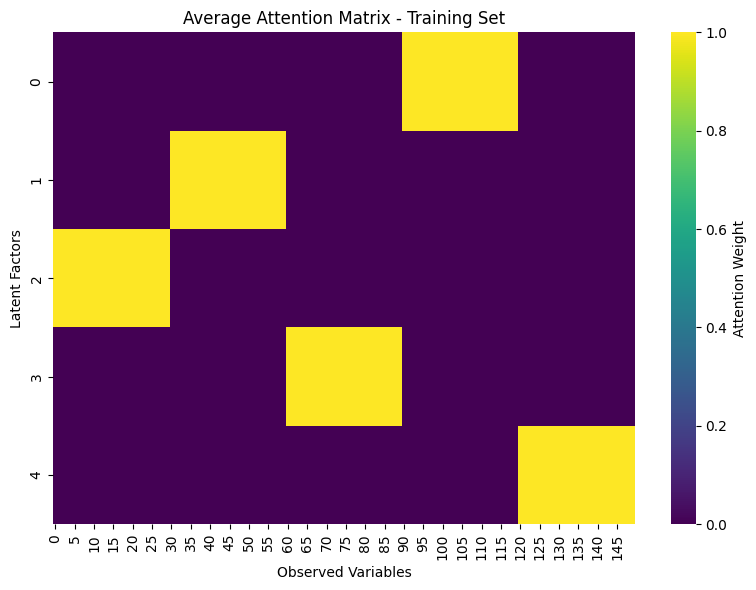

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns

def plot_attention_heatmap(attn_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        attn_matrix,
        cmap='viridis',
        vmin=0,
        vmax=1,
        cbar_kws={'label': 'Attention Weight'}
    )
    plt.title(title)
    plt.xlabel('Observed Variables')
    plt.ylabel('Latent Factors')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Directly plot the transposed average attention matrix for training set
avg_attn_train_transposed = avg_attn_train.T  # (output_dim, input_dim)
plot_attention_heatmap(avg_attn_train_transposed, 'Average Attention Matrix - Training Set')

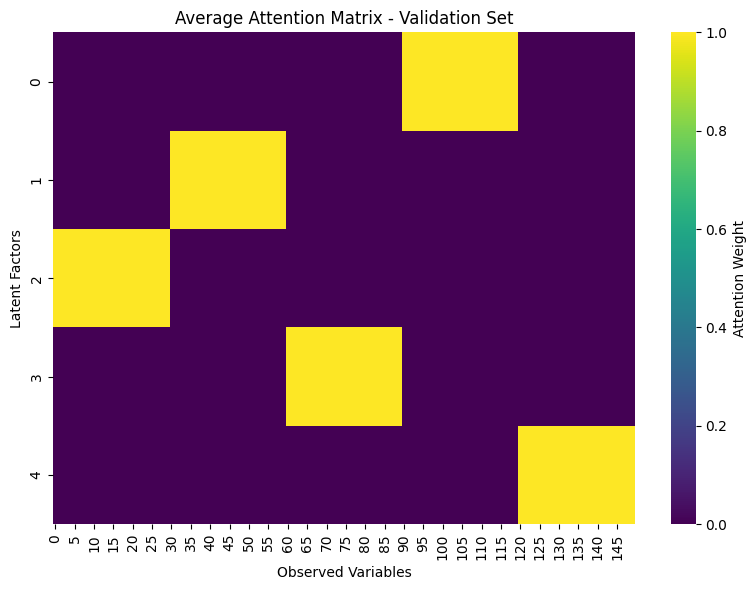

In [10]:
avg_attn_val_transposed = avg_attn_val.T
plot_attention_heatmap(avg_attn_val_transposed, 'Average Attention Matrix - Validation Set')